In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from src.utils_contributions import *
import torch.nn.functional as F
from src.contributions import ModelWrapper
import pandas as pd
import seaborn as sns
import json
import random
import statistics
random.seed(10)

import math

import os

from collections import defaultdict

import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model and tokenizer (BERT, DistilBERT, RoBERTa)

In [ ]:
model_name = 'bert'
dataset_name = 'sst2'
model, tokenizer, dataset_partition = load_model_data(model_name,dataset_name)

## Read AUPC csv

In [3]:
color_lines = {'ours': '#1f77b4',
                'grad': '#ff7f0e',
                'ig_l2': '#2ca02c',
                'ig_abs_mean': '#d62728',
                'grad_input_l2': '#9467bd',
                'grad_input_mean_abs_mean': '#8c564b',
                'rollout': '#e377c2',
                'norm2': '#7f7f7f',
                'ours2': '#bcbd22',
                'ours_l2': 'red',
                'norm' : 'green'}

In [50]:
model_name = 'multiberts-seed_0'
model_name = 'roberta' # bert_bin
dataset_name = 'yelp'
fidelity_type = 'comp'
bins = False
num_tokens = 50

bins_string = ''
if bins == True:
    num_tokens = 7
    bins_string = '_bins'
outfile = f'./data/AUPC/{model_name}_{dataset_name}_{fidelity_type}{bins_string}.json'
f = open(outfile)
pert_result = json.load(f)
methods_mean = {}
methods_list = pert_result.keys()
for method in methods_list:
    df_tmp = pd.DataFrame(pert_result[method])
    methods_mean[method] = df_tmp.describe().loc['mean'].to_list()
df=pd.DataFrame.from_dict(methods_mean,orient='index').transpose()
print(np.asarray(df).shape)
df = df.iloc[0:num_tokens-1]
df


(60, 10)


,ours,rollout,norm,norm2,grad,ig_l2,ig_abs_mean,grad_input_l2,grad_input_mean_abs_mean,ours_l2
0,0.993908,0.993908,0.993908,0.993908,0.993908,0.993908,0.993908,0.993908,0.993908,0.993908
1,0.969698,0.991915,0.987425,0.980895,0.973487,0.970359,0.969975,0.979940,0.972554,0.980936
2,0.939181,0.987930,0.982428,0.970583,0.953366,0.953792,0.954185,0.969997,0.955284,0.950506
3,0.919658,0.980911,0.975634,0.963811,0.939747,0.941627,0.939500,0.959477,0.942244,0.934664
4,0.905078,0.974118,0.963555,0.954474,0.930295,0.929767,0.926602,0.945051,0.931424,0.921985
5,0.882292,0.965914,0.949923,0.943860,0.916776,0.914189,0.910166,0.936376,0.918976,0.911380
6,0.862049,0.960425,0.944811,0.941042,0.908560,0.897448,0.898290,0.929502,0.906771,0.897720
7,0.848514,0.959253,0.936530,0.926917,0.902432,0.894934,0.884741,0.914820,0.900446,0.885578
8,0.838575,0.959455,0.929136,0.923716,0.898230,0.891595,0.876627,0.914527,0.900206,0.871218
9,0.822677,0.959153,0.919016,0.910316,0.890479,0.889254,0.866744,0.906553,0.887291,0.856240


In [51]:
def plot_word_deletion(word_deletion_df, methods_list, model_name, dataset_name, num_tokens, color_lines, fill=False, legend=True):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    
    fig = plt.figure(figsize=(10, 6),dpi=200)
    
    method_labels_dict = {'ours': 'ALTI', 'ours2': 'ALTI (+ LN2)', 'ours3': 'ALTI FULL', 'ours_l2': 'ALTI_L2',
                        'grad':r'Grad$_{\ell_2}$', 'grad_input_abs': 'Grad input',
                         'grad_input_clip': 'Gradxinput (clip)', 'grad_input_l2' : r'G$\times$I$_{\ell_2}$',
                         'grad_input_mean' : r'G$\times$I$_{\mu}$no abs',
                         'grad_input_mean_abs_mean': r'G$\times$I$_{\mu}$', 'ig_abs': 'IG (abs)',
                         'ig_clip': 'IG (clip)', 'ig_l2':r'IG$_{\ell_2}$', 'ig_mean': 'IG$_{\mu} no abs$',
                         'ig_abs_mean': 'IG$_{\mu}$', 'norm': 'Norm Rollout', 'norm2': 'Globenc', 'rollout': 'Rollout',
                         'blankout': 'blankout'}
    model_names = {'distilbert' : 'DistilBERT', 'bert': 'BERT', 'roberta': 'RoBERTa'}

    x_ticks = [i for i in range(0, num_tokens-1)]
    y_labels = ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
    y_ticks = np.arange(0,1.1,0.1)
    
    if fill:
        for method in methods_list:
            plt.plot(x_ticks, [float(e) for e in word_deletion_df[0][method]],
                    "--", label=method_labels_dict[method],
                    color = color_lines[method], linewidth=3.0, markersize=6, alpha=0.7)
            plt.fill_between(x_ticks, (np.array([float(e) for e in word_deletion_df[0][method]+word_deletion_df[1][method]])),
                            (np.array([float(e) for e in word_deletion_df[0][method]-word_deletion_df[1][method]])),color = color_lines[method],alpha=0.1)
            

    else:
        for method in methods_list:
            a  = plt.plot(x_ticks, [float(e) for e in word_deletion_df[method]],
                    "--", label=method_labels_dict[method], linewidth=3.0,
                    markersize=6, alpha=0.7,color = color_lines[method])
            #color_lines[method] = a[0].get_color()

    plt.grid(False, linewidth=0.25)# linestyle=(0, (5, 10))
    #plt.grid(color='grey', linestyle='-.')
    plt.xticks(range(0, num_tokens-1,5))#, fontsize=15)
    #np.arange(min(x), max(x)+1, 1.0)
    plt.yticks(y_ticks, y_labels)#, fontsize=15)

    # for i, spine in enumerate(plt.gca().spines.values()):
	#     if (i == 1) or (i==3):
	# 	    spine.set_visible(False)

    
    plt.xlabel("Number of tokens removed")
    if legend:
        plt.ylabel("Probability of predicted class")
        plt.legend(loc='lower left', framealpha=0.0)#, bbox_to_anchor=(0.5, 0.98), ncol=2, fancybox=True, shadow=True) , prop={'size': 16}


    # if 'multibert' in model_name:
    #     plt.title(f"BERT", fontsize=20)
    # else:
    #     plt.title(f"{model_names[model_name]}", fontsize=20)
    plt.title(f"{dataset_name.upper()}", fontsize=20)
    #plt.title(f"SST-2", fontsize=20)
    #plt.title(f"Yelp", fontsize=20)
    plt.savefig(f'img/fig_aupc_{model_name}_{dataset_name}.png', bbox_inches='tight')#transparent=True

    plt.show()

    #return color_lines

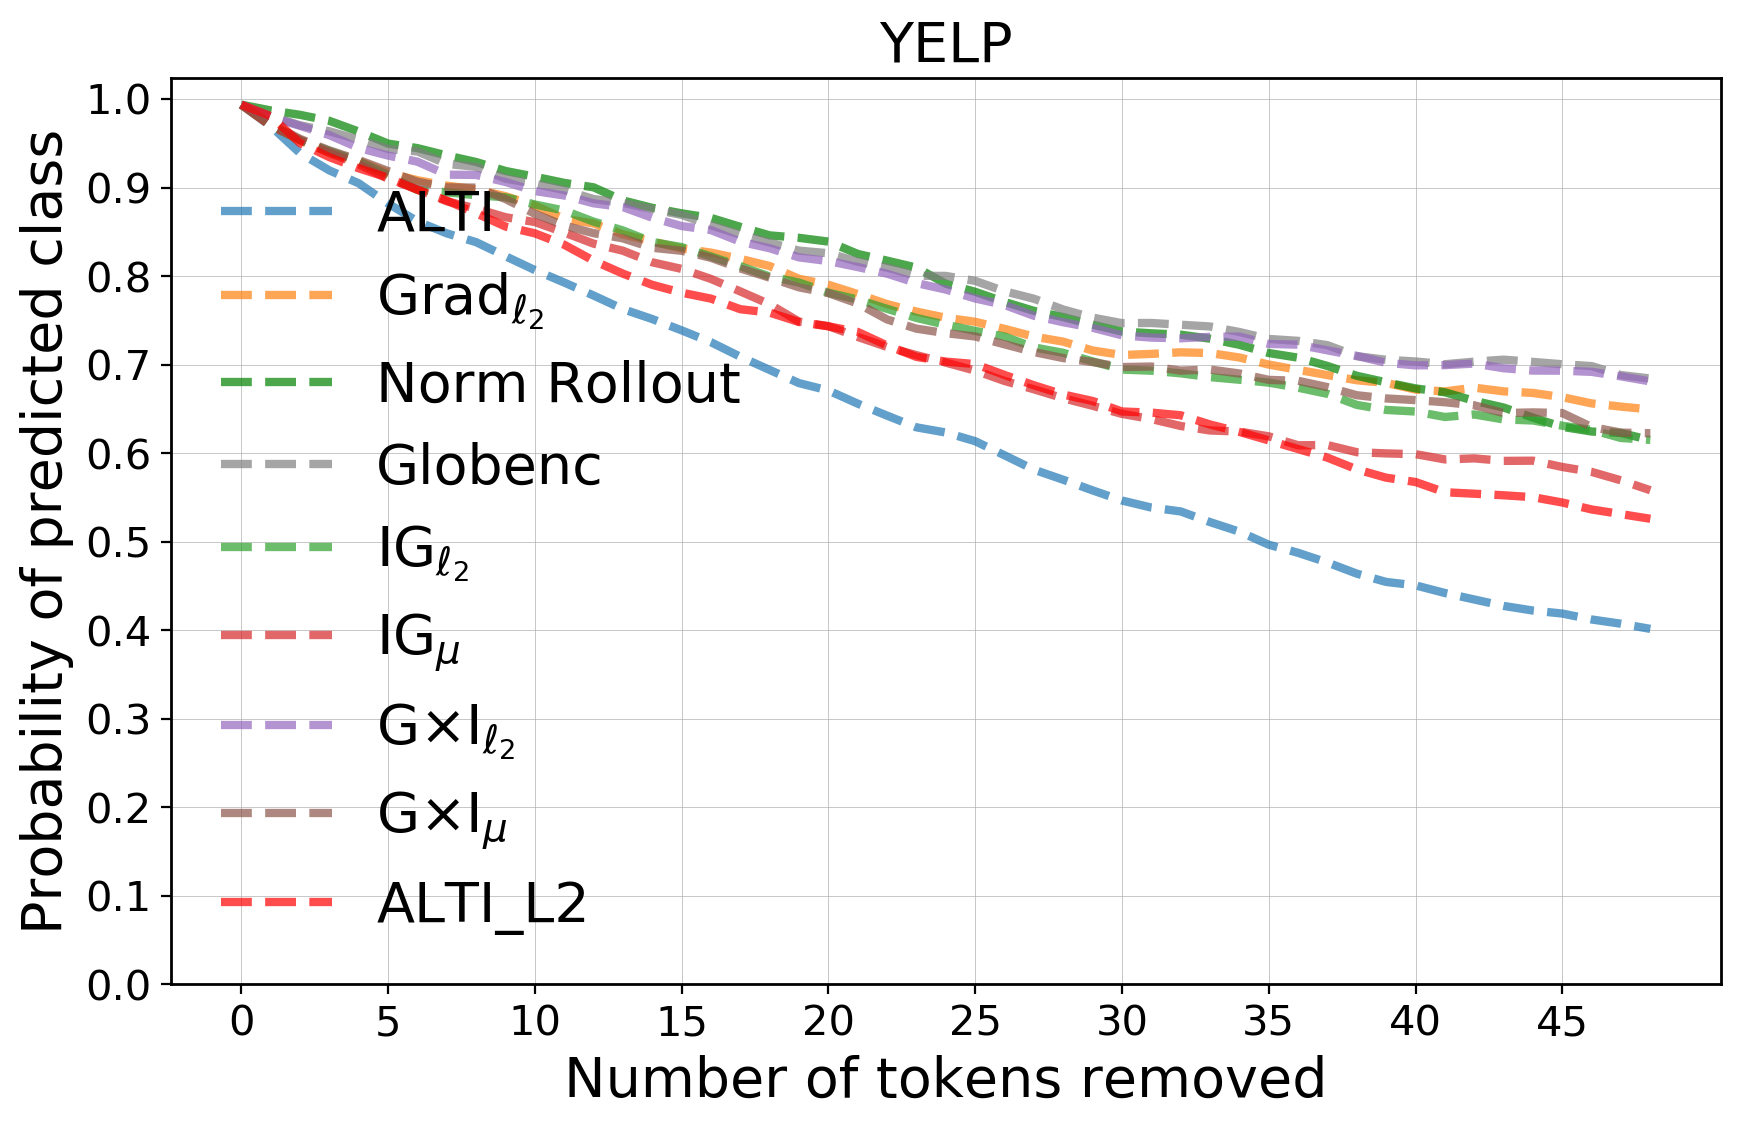

In [52]:
methods_list = ['ours', 'grad', 'norm', 'norm2', 'ig_l2', 'ig_abs_mean', 'grad_input_l2', 'grad_input_mean_abs_mean','ours_l2']#, 'rollout', 'norm2']
plot_word_deletion(df, methods_list, model_name, dataset_name, num_tokens, color_lines, legend=True)

## Faithfulness metrics

### Comprehesiveness/sufficiency

In [43]:
# model_name = 'multiberts-seed_0'
# #model_name = 'roberta'
# dataset_name = 'sst2'

# outfile = f'./data/AUPC/{model_name}_{dataset_name}_{fidelity_type}_bins.json'
# # We load comp file to access original prediction (prob prediction with full sentence)
# f_comp = open(f'./data/AUPC/{model_name}_{dataset_name}_comp_bins.json')
# pert_result_com = json.load(f_comp)
# f = open(outfile)
# pert_result = json.load(f)
#methods_mean = {}
methods_list = ['grad', 'ig_l2', 'ig_abs_mean', 'grad_input_l2', 'grad_input_mean_abs_mean', 'rollout', 'norm', 'norm2', 'ours_l2', 'ours']

dataset2model = {'sst2': 'multiberts-seed_0', 'imdb': 'bert',
                'sva': 'bert_bin', 'yelp': 'bert'}
#methods_list = pert_result.keys()
results_dict = {}


#for dataset_name in ['sst2', 'yelp','imdb', 'sva']:# ['sst2', 'sva', 'yelp', 'imdb']
for dataset_name in ['sst2', 'imdb', 'yelp', 'sva']:
    model_name = 'roberta'
    if model_name == 'bert' and dataset_name=='sst2':
        model_name = 'multiberts-seed_0'
    if dataset_name=='sva':
        model_name = model_name + '_bin'
        print(model_name)
    for fidelity_type in ['comp', 'suff']:
        #model_name = dataset2model[dataset_name]
        outfile = f'./data/AUPC/{model_name}_{dataset_name}_{fidelity_type}_bins.json'
        # We load comp file to access original prediction (prob prediction with full sentence)
        f_comp = open(f'./data/AUPC/{model_name}_{dataset_name}_comp_bins.json')
        pert_result_com = json.load(f_comp)
        f = open(outfile)
        pert_result = json.load(f)
        comprehensiveness_results = defaultdict(list)
        i = 0
        for i in range(len(pert_result_com['ours'])):
            for method in methods_list:
                comprehensiveness = 0
                original_prediction = pert_result_com[method][i][0]
                for bin in range(1,len(pert_result[method][i])):
                    if fidelity_type == 'comp':
                        local_comprehensiveness = original_prediction - pert_result[method][i][bin]
                    else:
                        local_comprehensiveness = original_prediction - pert_result[method][i][bin]
                    comprehensiveness += local_comprehensiveness
                comprehensiveness = comprehensiveness/6
                comprehensiveness_results[method].append(comprehensiveness)
        comprehensiveness_results_mean = {}
        for method in methods_list:
            comprehensiveness_results_mean[method] = statistics.mean(comprehensiveness_results[method])
        results_dict[dataset_name + fidelity_type] = comprehensiveness_results_mean



roberta_bin


In [44]:
model_name

'roberta_bin'

In [46]:
pd_fidelity = pd.DataFrame(results_dict).round(3)
pd_fidelity.to_csv(f'./data/AUPC/{model_name}_results.csv')
pd_fidelity

,sst2comp,sst2suff,imdbcomp,imdbsuff,yelpcomp,yelpsuff,svacomp,svasuff
grad,0.190,0.075,0.216,0.083,0.075,0.122,0.273,0.165
ig_l2,0.223,0.074,0.200,0.084,0.087,0.110,0.363,0.163
ig_abs_mean,0.231,0.067,0.215,0.083,0.102,0.094,0.351,0.161
grad_input_l2,0.187,0.081,0.183,0.109,0.066,0.149,0.280,0.169
grad_input_mean_abs_mean,0.191,0.078,0.225,0.080,0.083,0.120,0.270,0.167
rollout,0.076,0.179,0.077,0.197,0.031,0.208,0.223,0.183
norm,0.168,0.135,0.133,0.162,0.064,0.180,0.275,0.178
norm2,0.161,0.119,0.154,0.086,0.065,0.120,0.305,0.170
ours_l2,0.230,0.075,0.203,0.086,0.108,0.104,0.379,0.114
ours,0.269,0.057,0.266,0.050,0.138,0.070,0.390,0.109


In [23]:

methods_list = ['grad', 'ig_l2', 'ig_abs_mean', 'grad_input_l2', 'grad_input_mean_abs_mean', 'rollout', 'norm2', 'ours']

model_name = 'roberta'
results_dict = {}
for model_name in ['roberta', 'distilbert']:
    for dataset_name in ['sst2']:
        for fidelity_type in ['comp', 'suff']:
            outfile = f'./data/AUPC/{model_name}_{dataset_name}_{fidelity_type}_bins.json'
            # We load comp file to access original prediction (prob prediction with full sentence)
            f_comp = open(f'./data/AUPC/{model_name}_{dataset_name}_comp_bins.json')
            pert_result_com = json.load(f_comp)
            f = open(outfile)
            pert_result = json.load(f)
            comprehensiveness_results = defaultdict(list)
            i = 0
            for i in range(len(pert_result_com['ours'])):
                for method in methods_list:
                    comprehensiveness = 0
                    original_prediction = pert_result_com[method][i][0]
                    for bin in range(1,len(pert_result[method][i])):
                        if fidelity_type == 'comp':
                            local_comprehensiveness = original_prediction - pert_result[method][i][bin]
                        else:
                            local_comprehensiveness = original_prediction - pert_result[method][i][bin]
                        comprehensiveness += local_comprehensiveness
                    comprehensiveness = comprehensiveness/6
                    comprehensiveness_results[method].append(comprehensiveness)
            comprehensiveness_results_mean = {}
            for method in methods_list:
                comprehensiveness_results_mean[method] = statistics.mean(comprehensiveness_results[method])
            results_dict[model_name + fidelity_type] = comprehensiveness_results_mean


In [25]:
pd_fidelity = pd.DataFrame(results_dict).round(3)
pd_fidelity.to_csv('./data/AUPC/rob_distil_results.csv')
pd_fidelity

,robertacomp,robertasuff,distilbertcomp,distilbertsuff
grad,0.190,0.075,0.230,0.066
ig_l2,0.223,0.074,0.295,0.048
ig_abs_mean,0.231,0.067,0.279,0.064
grad_input_l2,0.187,0.081,0.235,0.065
grad_input_mean_abs_mean,0.191,0.078,0.237,0.065
rollout,0.076,0.179,0.152,0.147
norm2,0.161,0.119,0.240,0.072
ours,0.269,0.057,0.332,0.034


In [38]:
dataset_name = 'sst2'
fidelity_type = 'comp'
bins = False
num_tokens = 20

bins_string = ''
if bins == True:
    num_tokens = 7
    bins_string = '_bins'

full_arr = np.empty((num_tokens-1, len(methods_mean.keys()),0))
methods_list = ['ours', 'norm', 'norm2', 'grad','ig_abs_mean', 'ig_l2', 'grad_input_l2', 'grad_input_mean_abs_mean', 'ours2'] # ig_abs, grad_input_mean, grad_input_l2
for i in range(0,10):
    model_name = f'multiberts-seed_{i}'
    outfile = f'./data/AUPC/{model_name}_{dataset_name}_{fidelity_type}{bins_string}.json'
    f = open(outfile)
    pert_result = json.load(f)
    methods_mean = {}
    #methods_list = pert_result.keys()
    for method in methods_list:
        df = pd.DataFrame(pert_result[method])
        methods_mean[method] = df.describe().loc['mean'].to_list()
    df=pd.DataFrame.from_dict(methods_mean,orient='index').transpose()
    df = df.iloc[0:num_tokens-1]
    full_arr = np.concatenate((full_arr, np.expand_dims(np.asarray(df),-1)),axis=-1)
df_mean_seeds = pd.DataFrame(full_arr.mean(-1), columns = methods_list)
df_std_seeds = pd.DataFrame(full_arr.std(-1), columns = methods_list)


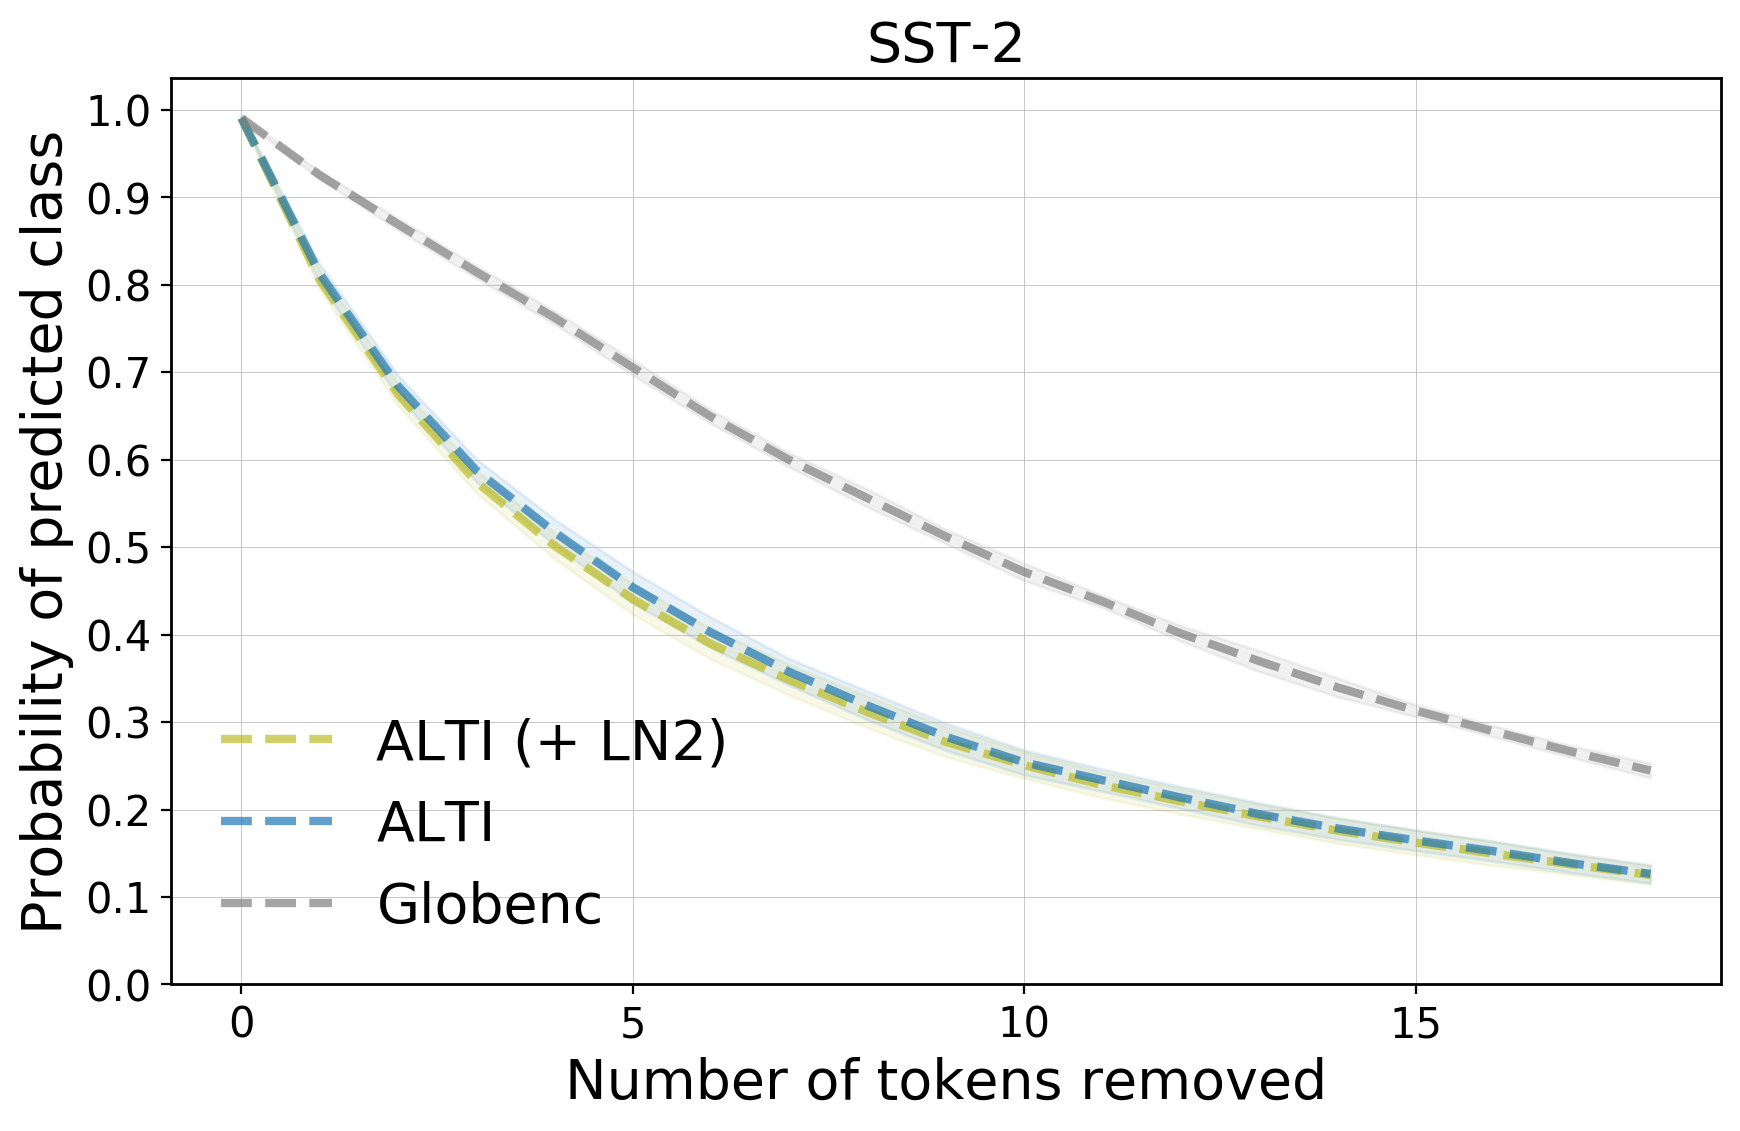

In [41]:
methods_list = ['ours', 'grad', 'ig_l2', 'ig_abs_mean', 'grad_input_l2', 'grad_input_mean_abs_mean']
methods_list = ['ours2', 'ours', 'norm2']
plot_word_deletion((df_mean_seeds,df_std_seeds), methods_list, model_name, dataset_name, num_tokens,color_lines, fill=True)